Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/test/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/test/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory( data_dir_train, seed=123, validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

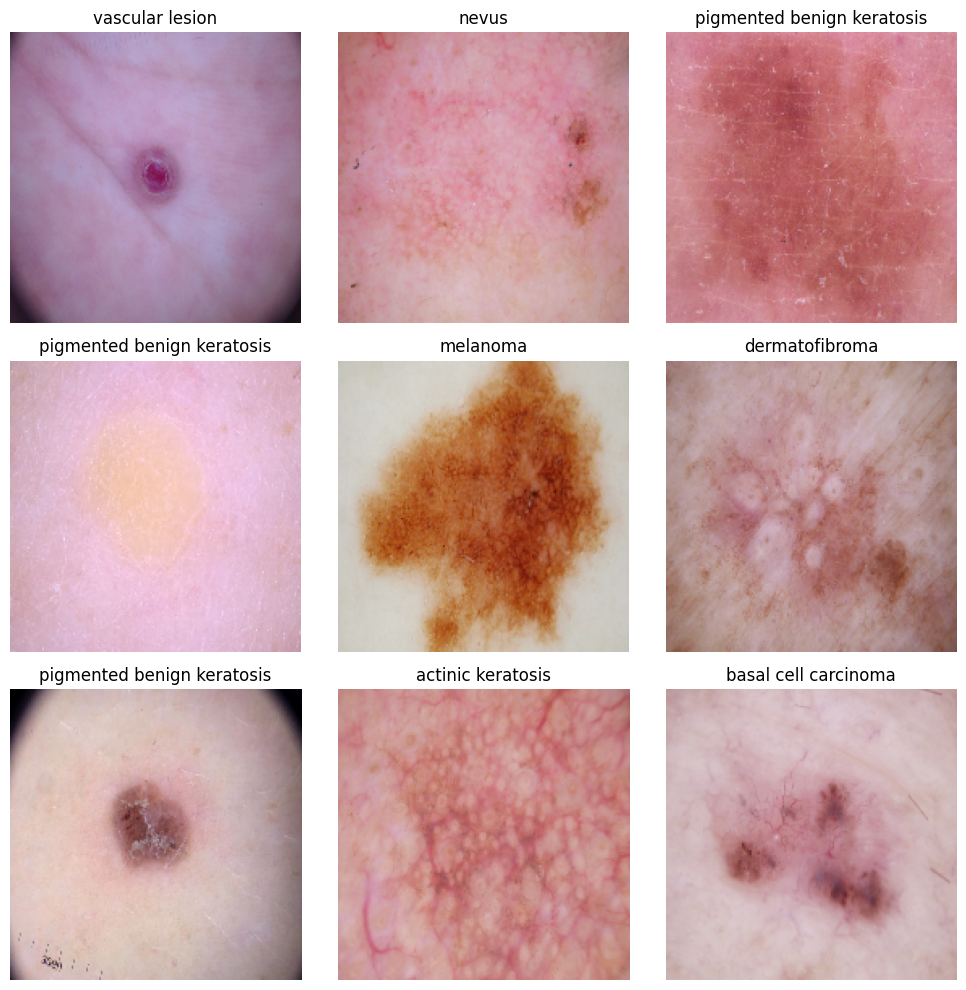

In [10]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for images, labels in train_ds.take(1):  # Takes only one batch from train_ds
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.set_title(class_names[labels[i]], fontsize=12)
            ax.axis("off")

plt.tight_layout()

### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
target_labels = 9  # Number of classes


model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(target_labels, activation='softmax')  # Softmax for multi-class classification
])




/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model


In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 111ms/step - accuracy: 0.2027 - loss: 2.2058 - val_accuracy: 0.2908 - val_loss: 1.9520
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3323 - loss: 1.8130 - val_accuracy: 0.4362 - val_loss: 1.5728
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4253 - loss: 1.6011 - val_accuracy: 0.5190 - val_loss: 1.4438
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5219 - loss: 1.3898 - val_accuracy: 0.5257 - val_loss: 1.3949
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5405 - loss: 1.3104 - val_accuracy: 0.4631 - val_loss: 1.5659
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5568 - loss: 1.2652 - val_accuracy: 0.5391 - val_loss: 1.3969
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5725 - loss: 1.1757 - val_accuracy: 0.5481 - val_loss: 1.3567
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6136 - loss: 1.0830 - val_accuracy: 0.5414 - val_loss: 

### Visualizing training results

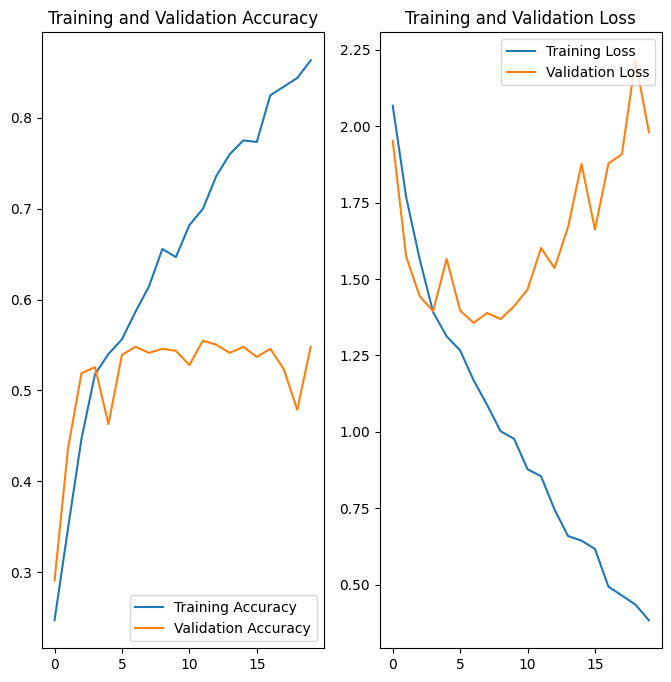

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

1. Model's training accuracy is 86%, whereas the validation accuracy is 55%.
2. High training accuracy ensures that the model has captured the complete details of the data, but the low validation accuracy ensures that the model is not efficient to capture the generalized information.

3. High training accuracy when compared to validation accuracy with significant diiference refers to overfitting. With limited training data, new samples will be created by applying slight modifications to existing data (e.g., horizontal/vertical flipping, minor rotations), which will then be used to train the model.

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
augmentation_data = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

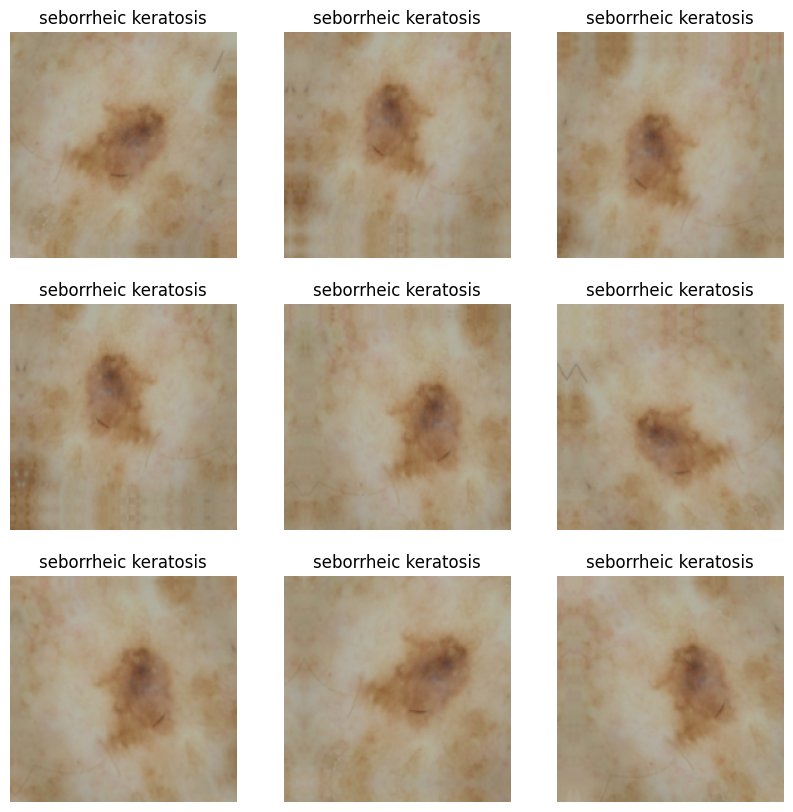

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
    augmentation_data,
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(target_labels, activation='softmax')  # Softmax for multi-class classification
])



### Compiling the model

In [21]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
history = history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)## your training code

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.1693 - loss: 2.2215 - val_accuracy: 0.3468 - val_loss: 1.9970
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3322 - loss: 1.9369 - val_accuracy: 0.4318 - val_loss: 1.7083
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4159 - loss: 1.6065 - val_accuracy: 0.4989 - val_loss: 1.4873
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5111 - loss: 1.4270 - val_accuracy: 0.4855 - val_loss: 1.5446
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4895 - loss: 1.4317 - val_accuracy: 0.5302 - val_loss: 1.3809
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5098 - loss: 1.3608 - val_accuracy: 0.5168 - val_loss: 1.4599
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4965 - loss: 1.4314 - val_accuracy: 0.5302 - val_loss: 1.4261
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5338 - loss: 1.3037 - val_accuracy: 0.5145 - v

### Visualizing the results

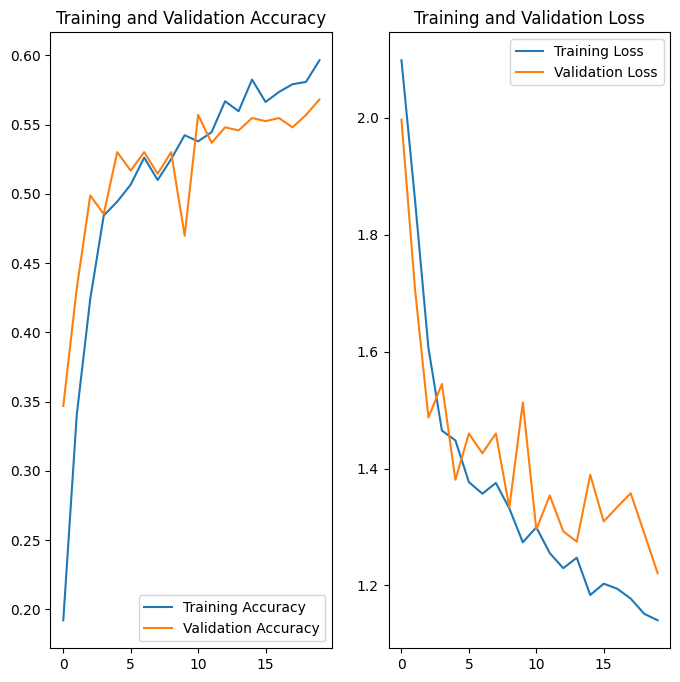

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The findings are
1. Aim to subside the overfitting has been sucessful. By observation, we can see that training accuracy is 59% and validation accuracy is 55%
2. There is no significant difference between them,
3. The accuracies of both of them are very less. This shows that the model is not efficient enough to capture the underlying features and the information of the data.


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
## Your code goes here.
import os
from glob import glob

# List all image paths and class labels
images_path_list = glob(f"{data_dir_train}/*/*.jpg")
lesions_list = [os.path.basename(os.path.dirname(img)) for img in images_path_list]

print(len(lesions_list))

2239


In [26]:
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/gdrive/My Drive/test/Train/nevus/ISIC_0000025.jpg', 'nevus'), ('/content/gdrive/My Drive/test/Train/nevus/ISIC_0000020.jpg', 'nevus'), ('/content/gdrive/My Drive/test/Train/nevus/ISIC_0000023.jpg', 'nevus'), ('/content/gdrive/My Drive/test/Train/nevus/ISIC_0000021.jpg', 'nevus'), ('/content/gdrive/My Drive/test/Train/nevus/ISIC_0000027.jpg', 'nevus')]


In [33]:
# View the image path and class label in a df
lesions_data = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_data.head()


,Image Path,Label
0,/content/gdrive/My Drive/test/Train/nevus/ISIC...,nevus
1,/content/gdrive/My Drive/test/Train/nevus/ISIC...,nevus
2,/content/gdrive/My Drive/test/Train/nevus/ISIC...,nevus
3,/content/gdrive/My Drive/test/Train/nevus/ISIC...,nevus
4,/content/gdrive/My Drive/test/Train/nevus/ISIC...,nevus


In [34]:
lesions_data[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


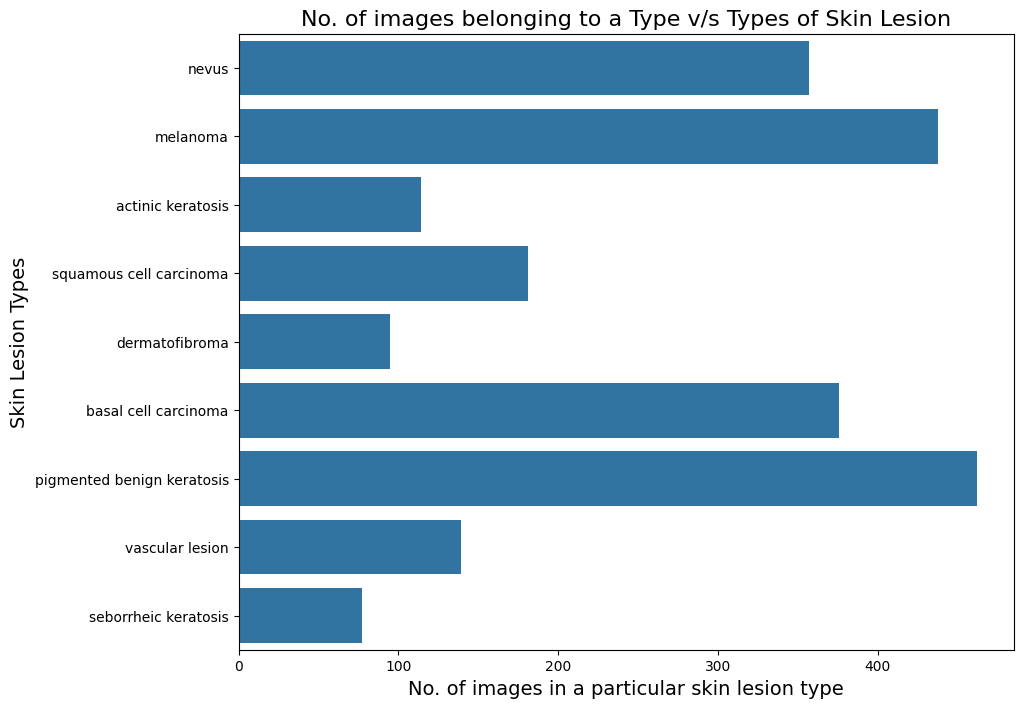

In [51]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.countplot(data=lesions_data, y="Label")
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

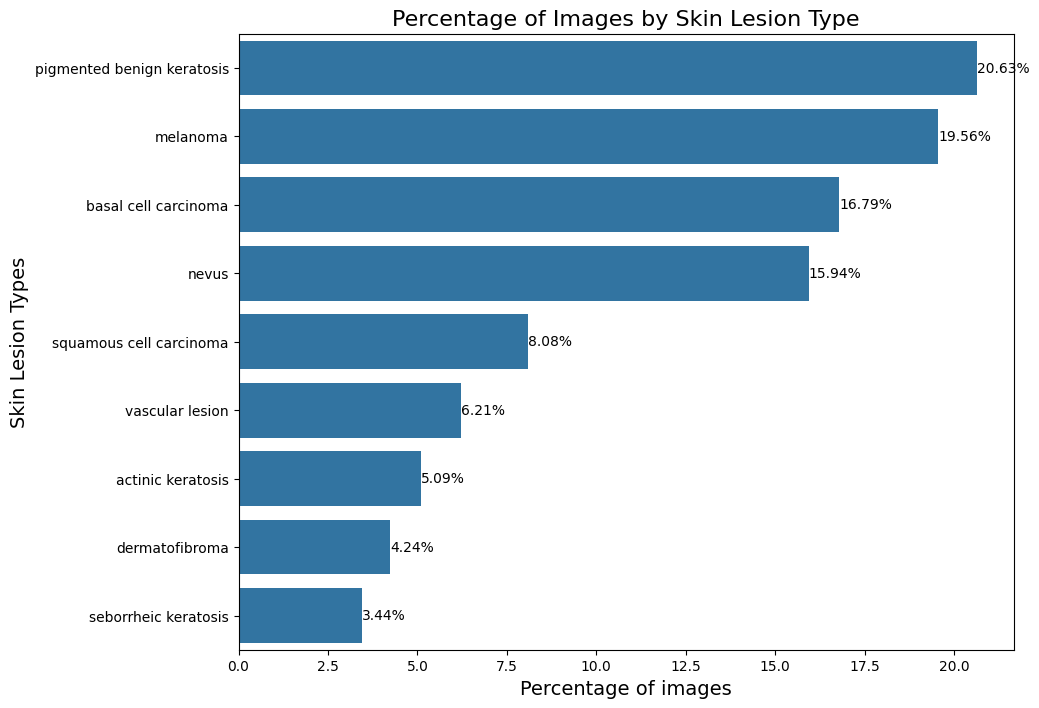

In [52]:
lesion_percentages = lesions_data['Label'].value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x=lesion_percentages.values, y=lesion_percentages.index)
plt.title('Percentage of Images by Skin Lesion Type', fontsize=16)
plt.xlabel('Percentage of images', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)

# Add percentage labels to each bar
for index, value in enumerate(lesion_percentages.values):
    plt.text(value, index, f'{value:.2f}%', va='center')

plt.show()

#### - The findings are 
1. Sebohrrheic keratosis class has the least number of samples. Around 3.44 % of all the samples

2. Pigment benign keratosis class dominates in terms of proportionate number of samples.

3. The above barplot clearly indicates the presence of class imbalance


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [39]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [40]:
path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/test/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D804A102AD0>: 100%|██████████| 500/500 [00:26<00:00, 19.04 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/test/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D804BF7FE80>: 100%|██████████| 500/500 [00:19<00:00, 26.18 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/test/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D804A3E6F20>: 100%|██████████| 500/500 [00:21<00:00, 23.47 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/test/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D8003AAFDF0>: 100%|██████████| 500/500 [01:26<00:00,  5.76 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/test/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2012x1956 at 0x7D805967F700>: 100%|██████████| 500/500 [01:19<00:00,  6.28 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/test/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D805846E080>: 100%|██████████| 500/500 [00:21<00:00, 23.54 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/test/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D80581C6FE0>: 100%|██████████| 500/500 [00:41<00:00, 12.11 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/test/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D804BC25FC0>: 100%|██████████| 500/500 [00:20<00:00, 24.40 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/test/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D80B9522830>: 100%|██████████| 500/500 [00:19<00:00, 25.72 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [41]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [46]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/test/Train/nevus/output/nevus_original_ISIC_0000239.jpg_ec132220-32ca-4de1-bfb3-3c7da0c35419.jpg',
 '/content/gdrive/My Drive/test/Train/nevus/output/nevus_original_ISIC_0000053.jpg_38ef5d35-86aa-41d0-9a3e-8abe9f3ecb91.jpg',
 '/content/gdrive/My Drive/test/Train/nevus/output/nevus_original_ISIC_0027958.jpg_2c38a9a3-cc95-4c82-acf4-0d85485d8b45.jpg',
 '/content/gdrive/My Drive/test/Train/nevus/output/nevus_original_ISIC_0000510.jpg_e0a0c0ab-353b-4034-9bbb-372b84b75d85.jpg',
 '/content/gdrive/My Drive/test/Train/nevus/output/nevus_original_ISIC_0000333.jpg_25de9547-e97d-4880-9183-062bf9229d45.jpg',
 '/content/gdrive/My Drive/test/Train/nevus/output/nevus_original_ISIC_0028854.jpg_2b2ba9a0-f043-4eb9-afed-5205ddaaab82.jpg',
 '/content/gdrive/My Drive/test/Train/nevus/output/nevus_original_ISIC_0000319.jpg_f7796286-12cf-49cb-973a-f52773c479a3.jpg',
 '/content/gdrive/My Drive/test/Train/nevus/output/nevus_original_ISIC_0000365.jpg_989c4698-6bfd-4fbe-99e6-e1bf717833b

In [47]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [48]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [55]:

df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])
new_df = pd.concat([lesions_data, df2], ignore_index=True)

In [56]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


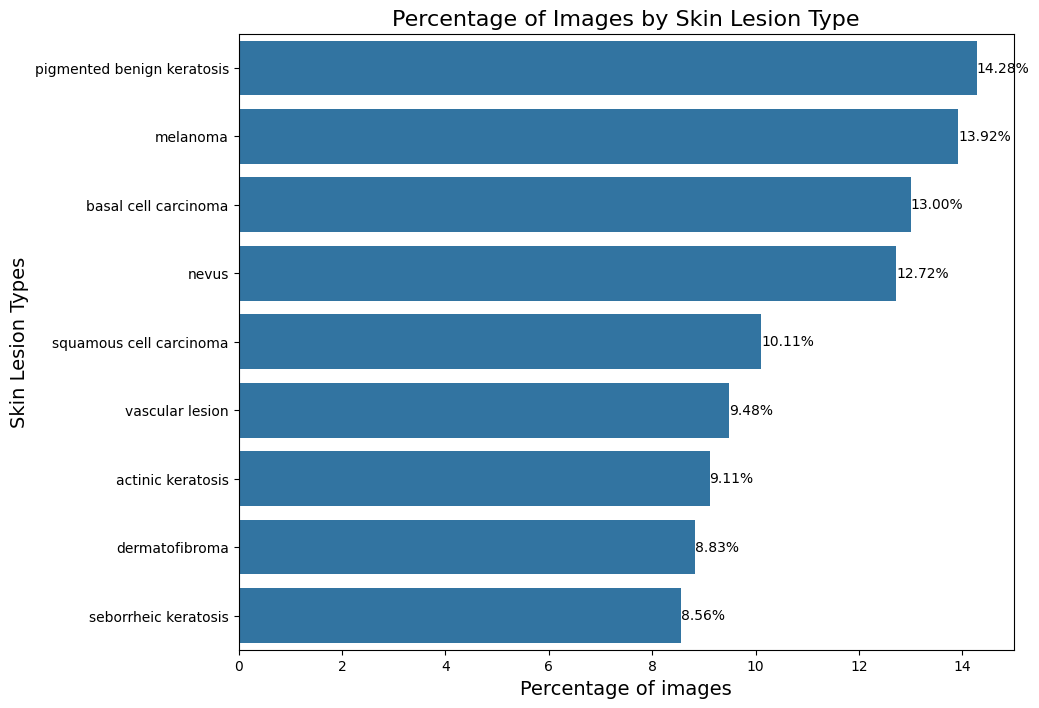

In [57]:
lesion_percentages = new_df['Label'].value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x=lesion_percentages.values, y=lesion_percentages.index)
plt.title('Percentage of Images by Skin Lesion Type', fontsize=16)
plt.xlabel('Percentage of images', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)

# Add percentage labels to each bar
for index, value in enumerate(lesion_percentages.values):
    plt.text(value, index, f'{value:.2f}%', va='center')

plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [58]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [60]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [62]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [63]:
## your code goes here


# Build the model
model = Sequential([
    augmentation_data,
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(target_labels, activation='softmax')  # Final output layer
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [64]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [65]:
epochs = 30
## Your code goes here

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 47s 246ms/step - accuracy: 0.2086 - loss: 3.4068 - val_accuracy: 0.1017 - val_loss: 26.8860
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 246ms/step - accuracy: 0.3165 - loss: 1.7833 - val_accuracy: 0.1767 - val_loss: 16.0550
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 246ms/step - accuracy: 0.3833 - loss: 1.6003 - val_accuracy: 0.3229 - val_loss: 3.0858
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 84s 256ms/step - accuracy: 0.4227 - loss: 1.4969 - val_accuracy: 0.4336 - val_loss: 1.3698
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 252ms/step - accuracy: 0.4438 - loss: 1.4116 - val_accuracy: 0.4202 - val_loss: 1.4393
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 85s 268ms/step - accuracy: 0.4629 - loss: 1.3615 - val_accuracy: 0.4506 - val_loss: 1.3680
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 265ms/step - accuracy: 0.4853 - loss: 1.3253 - val_accuracy: 0.3051 - val_loss: 1.9081
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 259ms/step - accuracy: 0.4841 - loss: 1.3078 - v

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The findings are
1. The results with BatchNormalization are Training Accuracy: 65 % , validation accuracy: 63%. There has been increase in the accuracies of training and validation.

2. Next we will further check in the absence of Batch Normalization



In [67]:
num_classes = target_labels  # Ensure target_labels is defined elsewhere in your code

# Create the model
model = Sequential([
    augmentation_data,
    layers.Rescaling(1./255),
    layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(rate=0.2),
    layers.Flatten(),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(target_labels, activation='softmax')  # Final output layer
])

In [68]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Utilize ModelCheckpoint to save the model or weights at specified intervals during training
checkpoint_callback = ModelCheckpoint(filepath="model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Implement EarlyStopping to halt training when a monitored metric stops improving
early_stopping_callback = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)




In [70]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,969,405 (45.66 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,979,604 (30.44 MB)

In [69]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.2443 - loss: 2.0217
Epoch 1: val_accuracy improved from -inf to 0.37936, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 248ms/step - accuracy: 0.2447 - loss: 2.0205 - val_accuracy: 0.3794 - val_loss: 1.7078
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.4014 - loss: 1.5613
Epoch 2: val_accuracy did not improve from 0.37936
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 237ms/step - accuracy: 0.4015 - loss: 1.5611 - val_accuracy: 0.3452 - val_loss: 1.8964
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.4299 - loss: 1.5248
Epoch 3: val_accuracy improved from 0.37936 to 0.48849, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 242ms/step - accuracy: 0.4301 - loss: 1.5242 - val_accuracy: 0.4885 - val_loss: 1.3298
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.4773 - loss: 1.3832
Epoch 4: val_accuracy improved from 0.48849 to 0.50631, saving model to model.keras

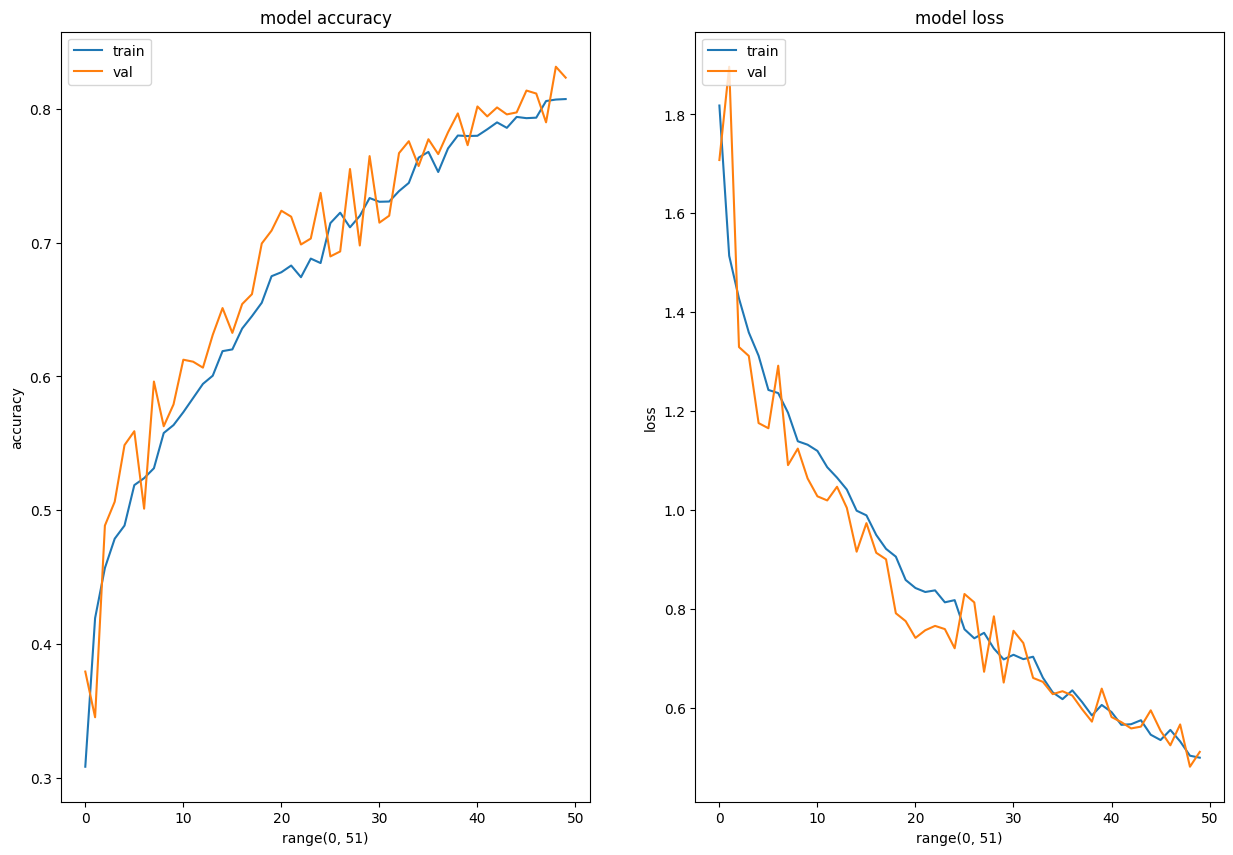

In [72]:
# Plot the training curves

epochs_range = range(epochs+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### The Findings are

1. The model without Batch Normalization showcases high accuracies in terms of both training(80%) and validation(81%).

2. The imbalance of rebalancing has reduced the effects of overfitting.It has also slightly increased the accuracies.

3. Wheras the model with Batch normalization has reduced the effects of overfitting but their accuracies were low (around 60-64%) for both training and validation.

4. The same above model with out batchnormalization has shot up the accuracies of both the data sets to around 81%.

5. This shows that the inclusion of batch normalization is considered to be not effective

6. The final model is effective in learning the general behaviour and underlying information of the dataset

### Model Evaluation


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Actual Class: melanoma
Predicted Class: melanoma


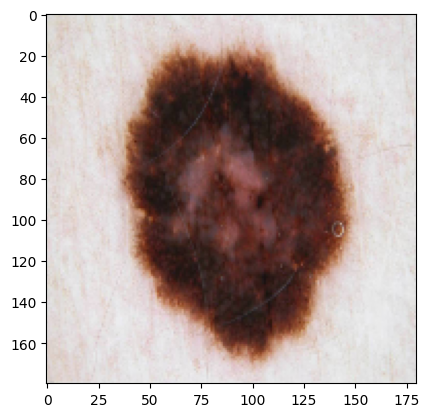

In [76]:
# Evaluating our model on some of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[3], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[3] +'\n'+ "Predicted Class: " + predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual Class: nevus
Predicted Class: nevus


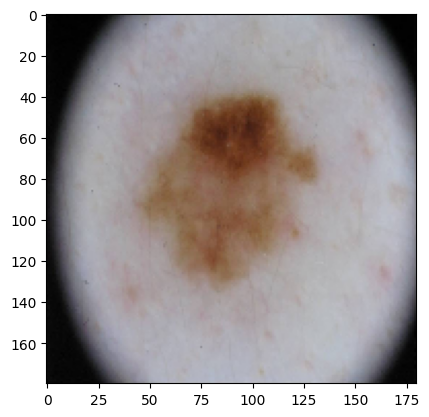

In [77]:


from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[4], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[4] +'\n'+ "Predicted Class: " + predicted_class)